## Digit Recognition of multiple MNIST characters

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(41)

Using TensorFlow backend.


4


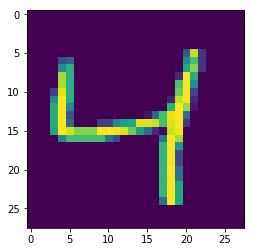

In [3]:
# Import mnist data from keras, view sample image
from keras.datasets import mnist
(image_train, label_train), (image_test, label_test)  =mnist.load_data()
plt.figure()
plt.imshow(image_train[2, :, :])
print label_train[2]


In [3]:
print image_train.shape[0]
print image_test.shape[0]

60000
10000


In [4]:
"""Generate sequence images by concatenating 5 numbers and provides labels for those sequences"""
def im_merge(im_in, label_in, num_out, max_num):
    data = np.ndarray(shape=(num_out,28,140))
    labels = np.ndarray(shape=(num_out,6))
    for ctr in range(0,num_out):
        im_list = []
        label_list=[]
        arr_len = im_in.shape[0]
        num_dig = np.random.randint(3,max_num+1)
        for itr in range(0,num_dig):
            index = np.random.randint(0,arr_len)
            im_list.append(im_in[index,:,:])
            label_list.append(label_in[index])
        concat = np.concatenate(im_list, axis=1)
        full_im = np.zeros((28,140))
        full_im[:,0:28*num_dig] += concat
        data[ctr]= full_im
        full_label = np.empty(6)
        full_label.fill(10)
        full_label[0:num_dig] = label_list
        full_label[5]=num_dig
        labels[ctr] = full_label
    return data , labels

[  1.   4.   0.  10.  10.   3.]


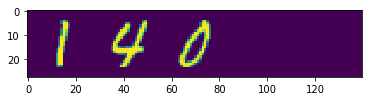

In [5]:
num_train = 40000
num_test = 4000
max_num = 5
train_data, label_train = im_merge(image_train, label_train, num_train, max_num)
test_data, label_test = im_merge(image_test, label_test, num_test, max_num)
plt.figure()
plt.imshow(train_data[2])
print label_train[2]
train_data = train_data/255
test_data = test_data/255
train_data = train_data.reshape(train_data.shape[0],1,train_data.shape[1],train_data.shape[2])
test_data = test_data.reshape(test_data.shape[0],1,test_data.shape[1],test_data.shape[2]).astype('float32')


In [6]:
print train_data.shape

(40000, 1, 28, 140)


In [7]:
#One-hot encode the labels for training
from keras.utils import np_utils
hot_train = np.zeros((num_train,max_num+1,11))
hot_test = np.zeros((num_test,max_num+1,11))
for digit in range(0,len(label_train[0])):
    hot_train[:,digit,:] = np_utils.to_categorical(label_train[:,digit],11)
    hot_test[:,digit,:] = np_utils.to_categorical(label_test[:,digit],11)
print label_train[2],hot_train[2]

[  1.   4.   0.  10.  10.   3.] [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [8]:
#Put labels into list format for compatibility with keras.
train_label_list = []
test_label_list = []
for itr in range(0,6):
    train_label_list.append(hot_train[:,itr,:])
    test_label_list.append(hot_test[:,itr,:])

In [33]:
from keras.models import Model
from keras.layers import Dense, Input, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, concatenate

In [10]:
#This is the CNN architecture that gave me the best results.
def large_cnn(num_outs):
    input_img=Input(shape=(1,28,140))
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop1 = Dropout(0.4)(pool2)
    flat = Flatten()(drop1)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    drop2 = Dropout(0.4)(den2)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(drop2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# build the model
conv_net = large_cnn(6)
# Fit the model
conv_net.fit(train_data, train_label_list, nb_epoch=10, batch_size=200, verbose=1, validation_split=.2)

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (5, 5), padding="valid", activation="relu", data_format="channels_first")`
  after removing the cwd from sys.path.
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`
  """
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), padding="valid", activation="relu", data_format="channels_first")`
  
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`
  import sys
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: User

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 145s - loss: 7.4257 - dense_3_loss: 1.6996 - dense_4_loss: 1.6341 - dense_5_loss: 1.6548 - dense_6_loss: 1.3438 - dense_7_loss: 0.8504 - dense_8_loss: 0.2431 - dense_3_acc: 0.4037 - dense_4_acc: 0.4218 - dense_5_acc: 0.4242 - dense_6_acc: 0.5539 - dense_7_acc: 0.7341 - dense_8_acc: 0.9410 - val_loss: 2.4946 - val_dense_3_loss: 0.5333 - val_dense_4_loss: 0.5185 - val_dense_5_loss: 0.5286 - val_dense_6_loss: 0.5324 - val_dense_7_loss: 0.3755 - val_dense_8_loss: 0.0062 - val_dense_3_acc: 0.8754 - val_dense_4_acc: 0.8697 - val_dense_5_acc: 0.8718 - val_dense_6_acc: 0.8620 - val_dense_7_acc: 0.8920 - val_dense_8_acc: 1.0000
Epoch 2/10
32000/32000 [==============================] - 18s - loss: 3.5008 - dense_3_loss: 0.7773 - dense_4_loss: 0.7634 - dense_5_loss: 0.7734 - dense_6_loss: 0.6543 - dense_7_loss: 0.4687 - dense_8_loss: 0.0637 - dense_3_acc: 0.7381 - dense_4_acc: 0.7443 - dense

In [36]:
# Final evaluation of the model
predictions = conv_net.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions[0:5]).argmax(axis=2).T
equiv = combined_pred==label_test[:,0:5]
print 'digit accuracy' , float(np.sum(equiv))/(5*num_test)
seq_acc = np.sum((equiv.sum(axis=1)==5))/float(num_test)
print 'sequence accuracy' , seq_acc

4000/4000 [==============================] - 0s     
digit accuracy 0.9785
sequence accuracy 0.89625


# digit accuracy 0.9785 sequence accuracy 0.89625
### The following network architectures were also tried and the results are shown below.
### Inception like model

In [34]:
def inception(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = concatenate([tower_1, tower_2, tower_3])
    
    flat = Flatten()(merged)
    drop = Dropout(0.3)(flat)
    next_rel = Dense(128,activation='relu')(drop)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(next_rel))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
# build the model
inception = inception(6)
# Fit the model
inception.fit(train_data, train_label_list, nb_epoch=10, batch_size=200, verbose=1, validation_split=.2)
# Final evaluation of the model
predictions = inception.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions[0:5]).argmax(axis=2).T
equiv = combined_pred==label_test[:,0:5]
print 'digit accuracy' , float(np.sum(equiv))/(5*num_test)
seq_acc = np.sum((equiv.sum(axis=1)==5))/float(num_test)
print 'sequence accuracy' , seq_acc

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  after removing the cwd from sys.path.
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", activation="relu")`
  
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", activation="relu")`
  import sys
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Upda

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 5s - loss: 4.0036 - dense_30_loss: 0.8741 - dense_31_loss: 0.8953 - dense_32_loss: 0.8720 - dense_33_loss: 0.7382 - dense_34_loss: 0.5324 - dense_35_loss: 0.0918 - dense_30_acc: 0.7196 - dense_31_acc: 0.7091 - dense_32_acc: 0.7185 - dense_33_acc: 0.7608 - dense_34_acc: 0.8298 - dense_35_acc: 0.9739 - val_loss: 1.9429 - val_dense_30_loss: 0.4725 - val_dense_31_loss: 0.4131 - val_dense_32_loss: 0.4723 - val_dense_33_loss: 0.3452 - val_dense_34_loss: 0.2352 - val_dense_35_loss: 0.0046 - val_dense_30_acc: 0.8585 - val_dense_31_acc: 0.8744 - val_dense_32_acc: 0.8529 - val_dense_33_acc: 0.8954 - val_dense_34_acc: 0.9270 - val_dense_35_acc: 0.9994
Epoch 2/10
32000/32000 [==============================] - 4s - loss: 1.7823 - dense_30_loss: 0.4190 - dense_31_loss: 0.4124 - dense_32_loss: 0.4223 - dense_33_loss: 0.3147 - dense_34_loss: 0.2088 - dense_35_loss: 0.0052 - dense_30_acc: 0.8711 -

## digit accuracy 0.94815 sequence accuracy 0.76775

In [38]:
def monster(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = concatenate([tower_1, tower_2, tower_3])
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(merged)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop = Dropout(0.2)(pool2)
    flat = Flatten()(drop)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(den2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
# build the reall big model
model = monster(6)
# Fit the model
model.fit(train_data, train_label_list, nb_epoch=10, batch_size=200, verbose=1, validation_split=.2)
# Evaluate the model
predictions = model.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions[0:5]).argmax(axis=2).T
equiv = combined_pred==label_test[:,0:5]
print 'digit accuracy' , float(np.sum(equiv))/(5*num_test)
seq_acc = np.sum((equiv.sum(axis=1)==5))/float(num_test)
print 'sequence accuracy' , seq_acc

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  after removing the cwd from sys.path.
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", activation="relu")`
  
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same", activation="relu")`
  import sys
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Upda

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 25s - loss: 6.6014 - dense_54_loss: 1.5352 - dense_55_loss: 1.4361 - dense_56_loss: 1.3691 - dense_57_loss: 1.2463 - dense_58_loss: 0.8155 - dense_59_loss: 0.1992 - dense_54_acc: 0.4602 - dense_55_acc: 0.5023 - dense_56_acc: 0.5221 - dense_57_acc: 0.5727 - dense_58_acc: 0.7422 - dense_59_acc: 0.9502 - val_loss: 3.1605 - val_dense_54_loss: 0.7073 - val_dense_55_loss: 0.6810 - val_dense_56_loss: 0.6278 - val_dense_57_loss: 0.6130 - val_dense_58_loss: 0.5202 - val_dense_59_loss: 0.0112 - val_dense_54_acc: 0.7704 - val_dense_55_acc: 0.7759 - val_dense_56_acc: 0.8030 - val_dense_57_acc: 0.7954 - val_dense_58_acc: 0.8244 - val_dense_59_acc: 0.9964
Epoch 2/10
32000/32000 [==============================] - 25s - loss: 2.5289 - dense_54_loss: 0.5840 - dense_55_loss: 0.5583 - dense_56_loss: 0.5313 - dense_57_loss: 0.4701 - dense_58_loss: 0.3754 - dense_59_loss: 0.0098 - dense_54_acc: 0.8120

## digit accuracy 0.95325 sequence accuracy 0.7875